# TranSYS application task

Aleksandra Perz

Task description
---

Use Ensembl either via Ensembl Biomart MartView (https://www.ensembl.org/biomart/martview) or preferentially programmatically via R Biomart package (R) or Ensembl API (Python or R ) to extract all mouse protein-coding genes for the human genome (GRCh38.p13). 

From the downloaded data plot the distribution of the number of orthologs. Note some human genes have zero orthologs, some have a single ortholog (121 relationship with the mouse ortholog) and some have more than one ortholog (one2many or many2many relationship).

To explore some functions of the human genes which do not have any mouse orthologs, extract these genes and use them as a target set for gene ontology enrichment analysis. There are some web-based tools for performing GO or pathway enrichment analysis (e.g. GOrilla http://cbl-gorilla.cs.technion.ac.il, ConsensusPathDB ( http://cpdb.molgen.mpg.de), DAVID ( https://david.ncifcrf.gov/tools.jsp) or you may prefer one of the R/Bioconductor packages.

Your slides should explain the concept of orthology, outline your approach to the question, show the histogram of the results, show the output of running the enrichment analysis (interpret top-scoring terms, and the statistical test used by the enrichment analysis tool) and summarise any interesting observations. If you don’t have enough time to complete the programming part of the task, explain your planned approach. Optional: nice visualisation.

In [1]:
%autoreload 2
from IPython.display import display
pd.set_option("display.max_colwidth", -1)


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

%matplotlib inline
sns.set(color_codes=True)
sns.set(font="monospace")
sns.set_context("talk")

from pybiomart import Server, Dataset
from gseapy import enrichr

In [2]:
palette = {
    'green' : sns.color_palette('muted')[2],
    'red'   : sns.color_palette('muted')[3],
    'black' : sns.light_palette('black')[-2],
    'gray'  : sns.light_palette('black')[-3],
    'blue'  : sns.color_palette('muted')[0],
    }

# 1. Retrieve the dataset

In [3]:
server = Server(host='http://www.ensembl.org')

In [4]:
# Find out which dataset name corresponds to the GRCh38.p13 build
mart = server['ENSEMBL_MART_ENSEMBL']
mart.list_datasets()[mart.list_datasets()['display_name'].str.contains('GRCh38.p13')]

name              display_name
174  hsapiens_gene_ensembl  Human genes (GRCh38.p13)

In [5]:
ds = Dataset(name='hsapiens_gene_ensembl', host='http://www.ensembl.org')

In [6]:
# Can't request attributes from different pages; must make two requests
query = pd.merge(
    ds.query(attributes=["ensembl_gene_id", "entrezgene_accession"]),
    ds.query(attributes=["ensembl_gene_id", "mmusculus_homolog_ensembl_gene"])
)

In [7]:
print("Number of nonreduntant ensembl IDs:",
    len(query['Gene stable ID'].unique())
    )

Number of nonreduntant ensembl IDs: 67087


In [8]:
print("Number of nonreduntant Entrez IDs:",
    len(query['NCBI gene accession'].unique())
    )

Number of nonreduntant Entrez IDs: 20491


# 2. Distribution of counts of mouse orthologs per human gene ID

In [9]:
# Get the counts of orthologs
data1 = query.groupby('NCBI gene accession', sort=False, observed=False)\
    .apply(lambda z: z.dropna().shape[0])#.value_counts()#.apply(np.log2)

In [10]:
def vbarplot(pandas_series, fontsize=20, figsize=(6,10)):
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=figsize)
    
    # Make the labels fit better
    ax = fig.add_subplot(111)
    fig.tight_layout()

    pos = [i for i in range(len(pandas_series))]
    bars = plt.barh(pos, pandas_series.values, color=palette['red'], height=1, linewidth=0.4)
    for bar in bars:
        plt.gca().text(max(pandas_series), 
                       bar.get_y()+bar.get_height()/3, 
                       str(int(bar.get_width())),
        ha='right', color=palette['black'], fontsize=fontsize)
    plt.yticks(pos, pandas_series.index, rotation='horizontal', fontsize=fontsize)
    ax.set_xlabel(pandas_series.name) 
    ax.set_ylabel(pandas_series.index.name) 
    
    return fig

In [11]:
data2 = data1\
    .value_counts()\
    .reindex(pd.Index([i for i in range(max(data1))]))\
    .sort_index()\
    .fillna(0)\
    .astype(int)
data2.name = "count"
data2.index.name = "no. of orthologs"

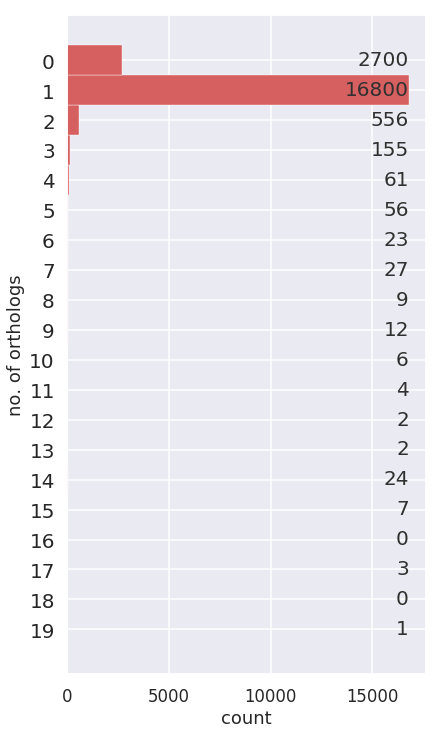

In [14]:
vbarplot(data2.reindex(index=data2.index[::-1]).tail(20))
plt.show()

In [15]:
def distribution_plot(pandas_series, fontsize=20, figsize=(10,6)):
    sns.set_style('darkgrid')
    fig = plt.figure(figsize=figsize)
    
    # Make the labels fit better
    ax = fig.add_subplot(111)
    fig.tight_layout()

    pos = [i for i in range(len(pandas_series))]
    plt.bar(pos, pandas_series.values, color=palette['red'], width=1, linewidth=0.4)

    density = gaussian_kde(pandas_series.tolist())
    density.covariance_factor = lambda : .8
    density._compute_covariance()
    plt.plot(pos, density(pos)*pandas_series.sum()) # multiply by 100%
    
    ax.set_ylabel(pandas_series.name) 
    ax.set_xlabel(pandas_series.index.name) 
        
    return fig

In [16]:
data3 = data2.apply(lambda x: np.log2(x+1))
data3.name = "log2(count)"

In [17]:
distribution_plot(data3.head(30))
plt.show()

In [18]:
pd.DataFrame(
    {"no. of orthologs":["0", "1", ">1"], 
     "count": [data2.loc[0], data2.loc[1], data2.loc[2:].sum()]
    },
).set_index("no. of orthologs")

count
no. of orthologs       
0                 2700 
1                 16800
>1                989

# 3. Get genes without mouse orthologs

In [19]:
data4 = data1[data1 == 0].index.tolist()

In [20]:
print("The number of genes without annotated mouse orthologs is", len(data4))

The number of genes without annotated mouse orthologs is 2700


# 4. GSEA

In [21]:
gene_sets=[
        "KEGG_2019_Human",                  # pathways
        "GO_Biological_Process_2018",       # functions
        'Genes_Associated_with_NIH_Grants', # just curious
    ]
keep_cols = ['Term', 'Adjusted P-value', 'Odds Ratio', 'Overlap']
#sns.set_style('whitegrid')

In [22]:
def enrichr_s(gene_list, gene_sets=gene_sets):
    o={}
    for gene_set in gene_sets:
        enr = enrichr(
                gene_list = gene_list,
                gene_sets = gene_set,
                )
        o[gene_set] = enr
    return o

In [23]:
enrichment = enrichr_s(data4)

In [24]:
for k,v in enrichment.items():
    print("Results for", k+":")
    display(v.results[keep_cols][v.results['Adjusted P-value']<0.05].head(10))

Results for KEGG_2019_Human:


Term  Adjusted P-value  Odds Ratio  Overlap
0  Herpes simplex virus 1 infection  2.606110e-45      2.920807    194/492
1  Systemic lupus erythematosus      1.557597e-09      2.729045    49/133 
2  Olfactory transduction            1.448116e-04      1.601602    96/444 
3  Alcoholism                        8.119482e-04      1.893004    46/180

Results for GO_Biological_Process_2018:


Term  \
0  regulation of nucleic acid-templated transcription (GO:1903506)          
1  regulation of cellular macromolecule biosynthetic process (GO:2000112)   
2  peptide cross-linking (GO:0018149)                                       
3  keratinocyte differentiation (GO:0030216)                                
4  epidermal cell differentiation (GO:0009913)                              

   Adjusted P-value  Odds Ratio  Overlap  
0  2.180631e-10      1.827485    150/608  
1  6.767039e-10      1.781528    152/632  
2  9.103964e-05      3.395062    22/48    
3  4.063009e-04      2.962963    24/60    
4  1.218183e-03      2.723312    25/68

Results for Genes_Associated_with_NIH_Grants:


Term  Adjusted P-value  Odds Ratio Overlap
0  T32HD007325  0.000004          5.128205    18/26 
1  U54RR025216  0.000012          4.761905    18/28 
2  K01HD000654  0.000022          7.407407    10/10 
3  R15GM104865  0.000017          5.291005    15/21 
4  R01AM020120  0.000126          6.734007    10/11 
5  R01GM040922  0.000399          3.456790    21/45 
6  R01ES020812  0.000608          6.666667    9/10  
7  R01AG034430  0.000532          6.666667    9/10  
8  R01GM090311  0.000473          6.666667    9/10  
9  R01GM067718  0.000549          3.703704    18/36

In [25]:
# Print genes associated with "Alcoholism"
x = enrichment['KEGG_2019_Human'].results
[i for i in x[x['Term'].str.contains("Alcoholism")].Genes.iloc[0].split(";")]

['HIST1H2BN',
 'SHC2',
 'HIST1H2BO',
 'HIST1H3J',
 'CALML6',
 'HIST1H2BI',
 'HIST1H2BL',
 'HIST1H2BK',
 'HIST2H4A',
 'HIST2H4B',
 'GNG5',
 'HIST1H3F',
 'HIST1H2AD',
 'HIST1H3G',
 'HIST1H2AG',
 'HIST3H2BB',
 'HIST1H3H',
 'HIST1H3I',
 'HIST1H3C',
 'HIST1H2AC',
 'HIST1H3D',
 'HIST1H3E',
 'HIST1H2AM',
 'HIST1H2AL',
 'HIST1H2AI',
 'HIST1H4K',
 'HIST1H2AH',
 'HIST1H4L',
 'H3F3C',
 'H2AFZ',
 'HIST1H2AK',
 'HIST1H2AJ',
 'HIST2H2BE',
 'HIST1H4A',
 'HIST4H4',
 'HIST3H3',
 'HIST1H2BF',
 'HIST1H4G',
 'HIST1H4H',
 'HIST1H2BH',
 'HIST1H2BG',
 'HIST1H2BB',
 'HIST1H4C',
 'HIST1H4D',
 'HIST1H4E',
 'HIST1H2BC']

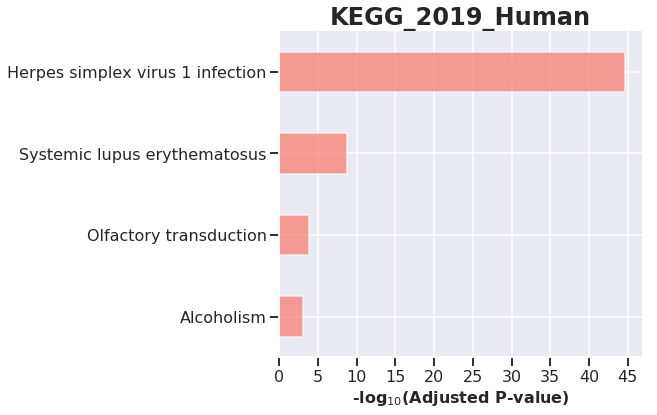

In [26]:
from gseapy.plot import barplot, dotplot
barplot(enrichment['KEGG_2019_Human'].res2d,title='KEGG_2019_Human',)
plt.show()

In [27]:
from gseapy.plot import barplot, dotplot
barplot(enrichment['GO_Biological_Process_2018'].res2d,title='GO BP',)
plt.show()

In [28]:
dotplot(enrichment['KEGG_2019_Human'].res2d, title='KEGG_2019_Human',)
plt.show()